Imports etc.


# Simon's code

In [ ]:
%pip install torch torchvision torchaudio tokenizers scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim

from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from tokenizers.processors import BertProcessing
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, Dataset
import pickle

Data processing code.

In [ ]:
import polars as pl
import pickle

files = ["./petfinder_study1.csv", "./petfinder_study2.csv"]

output_file = "./pet_description_dataset.pkl"

def create_entry(species, color, age, gender, size, text):  # unfortunately no name information, use a model to find names from descriptions?
	text = f"""Species: {species}
Color: {color}
Age: {age}
Gender: {gender}
Size: {size}
Description:
<START_DESCRIPTION>{text}<END_DESCRIPTION>"""
	return text


for file in files:
	df = pl.read_csv(file, infer_schema_length=10000)

	with open(output_file, "ab") as fp:
		for row in df.iter_rows():
			entry = create_entry(row[4], row[3], row[6], row[7], row[8], row[1])
			pickle.dump(entry, fp)  # we can read this out like a list with pickle
			print(entry)

Streaming output truncated to the last 5000 lines.
Description:
<START_DESCRIPTION>========================= About Our Rescue Group: The St. Mary's Animal Welfare League is a nonprofit, rescue organization that specializes in the rescue, care and placement of abused, neglected and homeless companion animals. Our animals are vaccinated, microchipped, spayed or neutered and receive medical treatment before being placed in carefully selected homes. We strive to educate the community in areas of humane education and responsible pet ownership as well as helping to control the pet overpopulation in our area by promoting the spaying and neutering of all companion animals. ===Come Meet Our Pets: Come meet our cats every Saturday from 10 a.m. to 2 p.m. located at Petco in California Maryland. We also have a cat facility in Callaway. The Cat Castle Rescue Center is located in the Callaway Village Shopping Center and is open every Saturday and Sunday from 11am to 3pm. Please contact info@smawl.or

Example tokenizer code from Chatgpt.

In [ ]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from tokenizers.processors import BertProcessing
import pickle

# Sample data (list of strings)
with open("pet_description_dataset.pkl", "rb") as file:
    text_data = []
    try:
        while True:
            text_data.append(pickle.load(file))
    except EOFError:
        pass

# Initialize the tokenizer
tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

# Define pre-tokenization rules and add trainer
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.WordPieceTrainer(vocab_size=3000, special_tokens=["<START_DESCRIPTION>", "<END_DESCRIPTION>", "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])

# Train tokenizer
tokenizer.train_from_iterator(text_data, trainer)

# Save the tokenizer
tokenizer.save("pet_description_tokenizer.json")

# Load the trained tokenizer
tokenizer = Tokenizer.from_file("pet_description_tokenizer.json")

# Example usage
encoded = tokenizer.encode("hello there general kenobi")
print(f"Encoded: {encoded.tokens}")   # Output: ['hello', 'there', 'general', 'kenobi']
print(f"IDs: {encoded.ids}")          # Output: Token IDs

Encoded: ['he', '##llo', 'there', 'general', 'k', '##en', '##o', '##b', '##i']
IDs: [280, 1821, 833, 2578, 81, 219, 102, 137, 128]


Data tokenization



In [ ]:
import json

# Apply the tokenizer to the original data and save the tokenized output
tokenized_data = []
with open("pet_description_dataset.pkl", "rb") as file:
    try:
        while True:
            text_data = pickle.load(file)
            encoded = tokenizer.encode(text_data)
            tokenized_data.append(encoded.tokens)  # Save the list of tokens
    except EOFError:
        pass

with open("pet_descriptions_tokenized.json", "w") as outfile:
    json.dump(tokenized_data, outfile)  # Save tokenized data to JSON



In [ ]:
import json

#Printing out the tokenized data folder for testing

with open("pet_descriptions_tokenized.json", "r") as f:
    tokenized_data = json.load(f)

# Print the first few tokenized sentences
for sentence in tokenized_data[:5]:
    print(sentence)

# Check the type of the data
print(type(tokenized_data))

['Species', ':', 'Dog', 'Color', ':', 'Other', 'Age', ':', 'Adult', 'Gender', ':', 'Female', 'Size', ':', 'Large', 'Description', ':', '<START_DESCRIPTION>', 'This', 'is', 'our', 'precious', 'A', '##ub', '##urn', '.', 'Is', '##n', "'", 't', 'she', 'beautiful', '?', 'Well', '....', 'she', 'is', 'just', 'as', 'beautiful', 'inside', 'as', 'outside', '.', 'She', 'deserves', 'so', 'much', 'more', 'than', 'living', 'at', 'the', 'shelter', '.', 'She', 'needs', 'a', 'mom', 'or', 'dad', 'or', 'both', '.', 'She', 'doesn', "'", 't', 'jump', 'up', 'on', 'you', ',', 'she', 'is', 'very', 'well', 'behaved', '.', 'If', 'she', 'hear', '##s', 'you', 'rais', '##e', 'your', 'v', '##o', '##ice', ',', 'it', 'h', '##ur', '##ts', 'her', 'feel', '##ings', 'because', 'she', 'is', 'so', 'well', 'behaved', 'that', 'she', 'doesn', "'", 't', 'understand', 'that', '.', 'She', 'will', 'sit', 'with', 'you', 'or', 'at', 'your', 'fee', '##t', 'as', 'long', 'as', 'you', 'like', 'for', 'her', 'to', '.', 'She', 'gets', 'al



Example training code from chatgpt.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

tokenizer = Tokenizer.from_file("pet_description_tokenizer.json")

# Hyperparameters
d_model = 512           # Embedding size
nhead = 8               # Number of attention heads
num_layers = 4          # Number of Transformer layers
dim_feedforward = 1024  # Dimension of feedforward network
dropout = 0.1
max_len = 1024           # Maximum length of input sequence
vocab_size = tokenizer.get_vocab_size() # Vocabulary size
lr = 1e-4               # Learning rate
epochs = 20            # Number of epochs

# Model Definition
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout, max_len):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, d_model))
        self.transformer = nn.Transformer(d_model, nhead, num_layers, num_layers, dim_feedforward, dropout)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src):
        src = self.embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src = src.transpose(0, 1)  # (batch_size, sequence_length, d_model) to (sequence_length, batch_size, d_model)
        output = self.transformer(src, src)  # Self-attention on the same input
        output = output.transpose(0, 1)  # (sequence_length, batch_size, d_model) to (batch_size, sequence_length, d_model)
        return self.fc_out(output)  # This will have shape (batch_size, sequence_length, vocab_size)

def dataset_generator():
    with open("pet_description_dataset.pkl", "rb") as file:
        try:
            while True:
                yield pickle.load(file)
        except EOFError:
            pass

# Sample data (dummy input for demonstration)
#data = torch.randint(0, vocab_size, (32, 20))  # Batch of sequences

class PetDataset(Dataset):
    def __init__(self, tokenizer, max_len):
        self.data = list(dataset_generator())  # Load all data from generator
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        encoded = self.tokenizer.encode(self.data[idx])
        input_ids = encoded.ids[:self.max_len]  # Truncate to max_len
        padding_length = self.max_len - len(input_ids)
        input_ids.extend([self.tokenizer.token_to_id("[PAD]")] * padding_length)  # Pad to max_len

        return torch.tensor(input_ids)

dataset = PetDataset(tokenizer, 1024)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

# Model instantiation
model = TransformerModel(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout, max_len).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token_to_id("[PAD]"))  # Ignore PAD token in loss calculation
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop for next token prediction
for epoch in range(epochs):
    total_loss = 0
    model.train()

    for batch in dataloader:
        batch = batch.to(device)  # Move batch to device
        optimizer.zero_grad()

        # Get model output
        output = model(batch[:, :-1])  # Use all tokens except the last as input
        loss = criterion(output.reshape(-1, vocab_size), batch[:, 1:].reshape(-1))  # Predict the next token

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}')
    torch.save(model.state_dict(), f"transformer_pet_description_model_{epoch}.pth")

torch.save(model.state_dict(), "transformer_pet_description_model.pth")

cpu


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Task 2 - clustering for data analysis and model enhancement (without TF-IDF of the pet descriptions)


In [ ]:
import polars as pl

# First, try increasing the infer_schema_length to examine more rows for schema inference
df1 = pl.read_csv("./petfinder_study1.csv", infer_schema_length=10000)

# For df2, use schema_overrides to specify float type for problematic columns
schema_overrides = {"Sixltr": pl.Float64, "Dic": pl.Float64}  # Specify correct types for the columns

# Now load the second CSV with the correct schema overrides
df2 = pl.read_csv("./petfinder_study2.csv", infer_schema_length=10000, schema_overrides=schema_overrides)

# # Check the shape and columns of each DataFrame
# print("df1 shape:", df1.shape)
# print("df2 shape:", df2.shape)

# print("df1 columns:", df1.columns)
# print("df2 columns:", df2.columns)

# List of columns that are in df1 but not in df2
missing_cols = ['published_date', 'pull_date', 'duration', 'ln_duration']

# Add missing columns to df2 with None values
for col in missing_cols:
    df2 = df2.with_columns(pl.lit(None).alias(col))

# Ensure the columns in df2 match the order of df1
df2 = df2.select(df1.columns)

# Now concatenate the two DataFrames
combined_df = pl.concat([df1, df2])

# Check data structure
print(combined_df.shape)
print(combined_df.head())

# Check missing values
missing_data = combined_df.null_count()
print(missing_data)


(860809, 108)
shape: (5, 108)
┌─────────┬────────────────────────┬─────────┬────────────┬───┬───────┬─────────┬─────────┬────────┐
│ pid     ┆ text                   ┆ country ┆ color_code ┆ … ┆ Quote ┆ Apostro ┆ Parenth ┆ OtherP │
│ ---     ┆ ---                    ┆ ---     ┆ ---        ┆   ┆ ---   ┆ ---     ┆ ---     ┆ ---    │
│ i64     ┆ str                    ┆ str     ┆ str        ┆   ┆ f64   ┆ f64     ┆ f64     ┆ f64    │
╞═════════╪════════════════════════╪═════════╪════════════╪═══╪═══════╪═════════╪═════════╪════════╡
│ 8942078 ┆ This is our precious   ┆ US      ┆ Other      ┆ … ┆ 0.0   ┆ 3.09    ┆ 0.0     ┆ 0.0    │
│         ┆ Auburn. I…             ┆         ┆            ┆   ┆       ┆         ┆         ┆        │
│ 9093344 ┆ Hello. My name is      ┆ US      ┆ Other      ┆ … ┆ 0.0   ┆ 0.0     ┆ 0.0     ┆ 0.0    │
│         ┆ Gabriel, tho…          ┆         ┆            ┆   ┆       ┆         ┆         ┆        │
│ 9174804 ┆ Hi, I'm PIstachio! I   ┆ US      ┆ Other      ┆ …

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Use the following features for clustering
selected_features = ['Tone', 'affect', 'posemo', 'negemo', 'swear', 'netspeak', 'informal', 'cogproc', 'insight', 'cause', 'social', 'family', 'friend', 'female', 'male']

df_selected = combined_df.select(selected_features)

# Ensure that the selected features are numerical
df_selected = df_selected.to_pandas()

# Standardize the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected)


In [ ]:
from sklearn.cluster import KMeans

# Define the number of clusters (you can experiment with this number)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(scaled_features)

# Add the cluster labels to your dataframe
df_selected['cluster'] = kmeans.labels_

# Check cluster distribution
cluster_counts = pd.Series(kmeans.labels_).value_counts()
print("Cluster distribution:\n", cluster_counts)

# Add the cluster labels back to the original dataframe
combined_df = combined_df.with_columns(pl.Series(kmeans.labels_).alias("cluster"))

# Display the first few rows with the cluster assignment
print("Combined DataFrame with clusters:\n", combined_df.head())


Cluster distribution:
 4    365230
0    174138
1    161216
2    122225
3     38000
Name: count, dtype: int64
Combined DataFrame with clusters:
 shape: (5, 109)
┌─────────┬──────────────────────┬─────────┬────────────┬───┬─────────┬─────────┬────────┬─────────┐
│ pid     ┆ text                 ┆ country ┆ color_code ┆ … ┆ Apostro ┆ Parenth ┆ OtherP ┆ cluster │
│ ---     ┆ ---                  ┆ ---     ┆ ---        ┆   ┆ ---     ┆ ---     ┆ ---    ┆ ---     │
│ i64     ┆ str                  ┆ str     ┆ str        ┆   ┆ f64     ┆ f64     ┆ f64    ┆ i32     │
╞═════════╪══════════════════════╪═════════╪════════════╪═══╪═════════╪═════════╪════════╪═════════╡
│ 8942078 ┆ This is our precious ┆ US      ┆ Other      ┆ … ┆ 3.09    ┆ 0.0     ┆ 0.0    ┆ 0       │
│         ┆ Auburn. I…           ┆         ┆            ┆   ┆         ┆         ┆        ┆         │
│ 9093344 ┆ Hello. My name is    ┆ US      ┆ Other      ┆ … ┆ 0.0     ┆ 0.0     ┆ 0.0    ┆ 4       │
│         ┆ Gabriel, tho…       

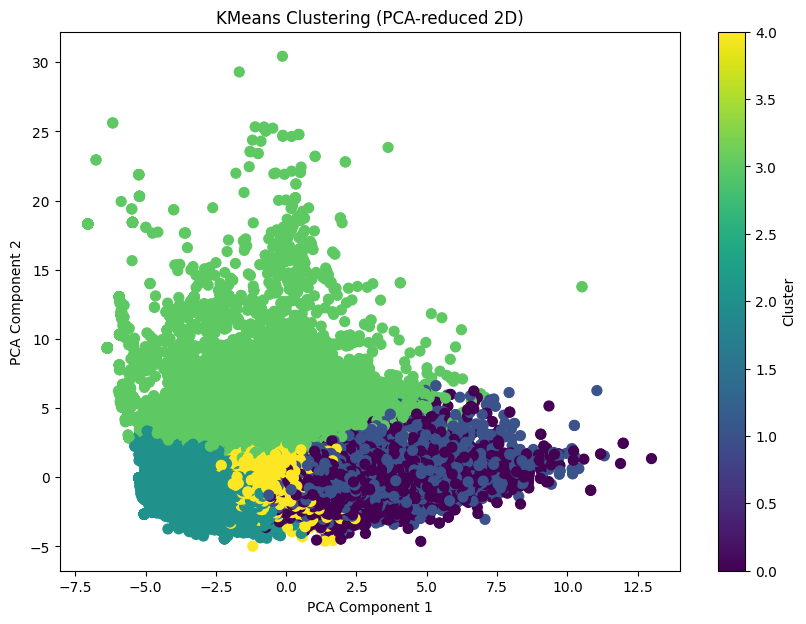

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to reduce the data to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Scatter plot of the two principal components with cluster coloring
plt.figure(figsize=(10, 7))

# Plot each cluster with a different color
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans.labels_, cmap='viridis', s=50)

# Label the plot
plt.title('KMeans Clustering (PCA-reduced 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Display the plot
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# from sklearn.metrics import silhouette_score, davies_bouldin_score

# # Checking if the clustering is performing well

# # 1. Silhouette Score
# silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
# print(f'Silhouette Score: {silhouette_avg:.4f}')

# # 2. Davies-Bouldin Index
# davies_bouldin = davies_bouldin_score(scaled_features, kmeans.labels_)
# print(f'Davies-Bouldin Index: {davies_bouldin:.4f}')

# # 3. Within-cluster sum of squares (inertia)
# within_cluster_ss = kmeans.inertia_
# print(f'Within-Cluster Sum of Squares (WCSS): {within_cluster_ss:.4f}')

# # Plotting the inertia for different numbers of clusters (Elbow Method)
# wcss = []

# # Test different numbers of clusters
# for i in range(1, 11):
#     kmeans_test = KMeans(n_clusters=i, random_state=42)
#     kmeans_test.fit(scaled_features)
#     wcss.append(kmeans_test.inertia_)

# # Elbow plot
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
# plt.title('Elbow Method for Optimal K')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
# plt.xticks(range(1, 11))
# plt.grid(True)
# plt.show()


In [ ]:
# Using Clusters to Improve the Model
# Once you've grouped pets into clusters, you can use this information to enhance the training of your Transformer model:

# Cluster-Specific Models: Train separate Transformer models for each cluster. For example, a model trained on pets in cluster 1
# may generate better descriptions for older pets, while a model trained on cluster 2 may work better for small dogs.

# Feature-Enhanced Training: Add the cluster labels as additional input features to your Transformer model, allowing it
# to condition its output based on the pet's cluster.

# You can modify the dataset class to include cluster information:

# class PetDatasetWithClusters(Dataset):
#     def __init__(self, tokenizer, max_len, clusters):
#         self.data = list(dataset_generator())
#         self.tokenizer = tokenizer
#         self.max_len = max_len
#         self.clusters = clusters  # Add clusters to the dataset

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         encoded = self.tokenizer.encode(self.data[idx])
#         input_ids = encoded.ids[:self.max_len]
#         padding_length = self.max_len - len(input_ids)
#         input_ids.extend([self.tokenizer.token_to_id("[PAD]")] * padding_length)

#         # Add cluster information as an additional feature (e.g., as part of the input sequence)
#         cluster_info = self.clusters[idx]
#         return torch.tensor(input_ids), torch.tensor(cluster_info)


# Data Exploration

In [ ]:
import polars as pl

# VOLUME (How much data is there?)

# Sample Polars DataFrame
# combined_df = ... # Your existing DataFrame

# Number of rows and columns in the combined dataset
rows, columns = combined_df.shape
print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")

# Estimating memory usage of the dataset
memory_usage = 0

# Define the size in bytes for common Polars dtypes
dtype_sizes = {
    'Int64': 8,
    'Float64': 8,
    'Utf8': 50,  # Assuming an average of 50 bytes for string columns
    'Boolean': 1,
    # Add more types if necessary
}

# Loop through columns and calculate memory usage
for column in combined_df.columns:
    dtype = str(combined_df[column].dtype)
    column_size = dtype_sizes.get(dtype, 0)  # Default to 0 if dtype not found
    memory_usage += column_size * combined_df[column].len()

# Convert memory usage to MB
memory_usage_mb = memory_usage / (1024**2)  # Convert to MB
print(f"Estimated memory usage: {memory_usage_mb:.2f} MB")


Number of rows: 860809
Number of columns: 108
Estimated memory usage: 637.04 MB


In [ ]:
# VARIETY (What types of data do you have?)

# Data types of each column
data_types = combined_df.dtypes
print(data_types)

# Check for missing values
missing_values = combined_df.null_count()
print(f"Missing values per column:\n{missing_values}")

[Int64, String, String, String, String, String, String, String, String, Int64, String, String, Int64, Float64, String, Int64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64]
Missing values per column:
shape: (1, 108)
┌──

In [ ]:
# VELOCITY (How fast is the data generated or updated?)

# Convert the 'published_date' and 'pull_date' columns to datetime if not already
combined_df = combined_df.with_columns([
    pl.col("published_date").str.strptime(pl.Date, "%m/%d/%y"),
    pl.col("pull_date").str.strptime(pl.Date, "%m/%d/%y")
])

# Sort the dataframe by 'published_date' to ensure correct chronological order
combined_df = combined_df.sort("published_date")

# Get the range of dates (velocity aspect)
min_date = combined_df["published_date"].min()
max_date = combined_df["published_date"].max()
print(f"Data covers from {min_date} to {max_date}")

# Calculate the frequency of new records
# Ensure the differences are positive by calculating 'diff' after sorting
date_diff = combined_df["published_date"].diff().drop_nulls()

# Convert the difference from 'timedelta' (milliseconds by default) to days
# Convert it by dividing the timedelta (in milliseconds) by the number of milliseconds in a day (24 * 60 * 60 * 1000)
date_diff_days = date_diff.cast(pl.Float64) / (24 * 60 * 60 * 1000)

# Calculate the average time gap between records in days
average_time_gap = date_diff_days.mean()
print(f"Average time gap between records: {average_time_gap:.2f} days")

Data covers from 2007-08-18 to 2018-08-01
Average time gap between records: 0.02 days


In [ ]:
import polars as pl

# VERACITY (How reliable and accurate is the data?)

# 1. Check for null values
null_counts = combined_df.null_count()
print("Null value counts per column:")
print(null_counts)

# 2. Check for outliers using summary statistics
summary_stats = combined_df.describe()
print("Summary statistics for numerical columns:")
print(summary_stats)

# 3. Check unique value counts for categorical columns
categorical_columns = ['pet', 'gender', 'color_code', 'size']  # Add any other categorical columns as needed
for column in categorical_columns:
    unique_count = combined_df[column].n_unique()
    print(f"Unique values in '{column}': {unique_count}")

# 4. Check data type consistency
data_types = combined_df.dtypes
print("Data types of each column:")
print(data_types)

# 5. Check for duplicates by counting occurrences of each row
duplicates_df = combined_df.group_by(combined_df.columns).agg(pl.len().alias("count"))

# Filter to get only the duplicate rows (count > 1)
duplicate_records = duplicates_df.filter(pl.col("count") > 1)

# Number of duplicate records
num_duplicates = duplicate_records.shape[0]

# Display results for duplicates
print(f"Number of duplicate records: {num_duplicates}")
if num_duplicates > 0:
    print("Duplicate records:")
    print(duplicate_records)
else:
    print("No duplicate records found.")


Null value counts per column:
shape: (1, 108)
┌─────┬──────┬─────────┬────────────┬───┬───────┬─────────┬─────────┬────────┐
│ pid ┆ text ┆ country ┆ color_code ┆ … ┆ Quote ┆ Apostro ┆ Parenth ┆ OtherP │
│ --- ┆ ---  ┆ ---     ┆ ---        ┆   ┆ ---   ┆ ---     ┆ ---     ┆ ---    │
│ u32 ┆ u32  ┆ u32     ┆ u32        ┆   ┆ u32   ┆ u32     ┆ u32     ┆ u32    │
╞═════╪══════╪═════════╪════════════╪═══╪═══════╪═════════╪═════════╪════════╡
│ 0   ┆ 0    ┆ 0       ┆ 0          ┆ … ┆ 0     ┆ 0       ┆ 0       ┆ 0      │
└─────┴──────┴─────────┴────────────┴───┴───────┴─────────┴─────────┴────────┘
Summary statistics for numerical columns:
shape: (9, 109)
┌────────────┬─────────────┬─────────────┬─────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ statistic  ┆ pid         ┆ text        ┆ country ┆ … ┆ Quote    ┆ Apostro  ┆ Parenth  ┆ OtherP   │
│ ---        ┆ ---         ┆ ---         ┆ ---     ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str        ┆ f64         ┆ str        